In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})



In [2]:
data=soup.find("tr",{"id":"h_tr_id_SOKM"})


In [3]:
data=soup.find("td",{"id":"h_td_fiyat_id_SOKM"})
text=data.text

In [4]:
text=text.replace(',', '.')
text=float(text)
text

32.3

In [5]:
sok=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/sok.csv")
sok.index=pd.to_datetime(sok["Date"])


In [6]:
del sok["Date"]

In [7]:
sok=pd.DataFrame(sok)

In [8]:
sok

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,12.89,12.53,12.89,12.49,8.56M,3.29%
2021-01-05,13.05,12.94,13.30,12.84,21.95M,1.24%
2021-01-06,12.88,13.14,13.20,12.87,9.72M,-1.30%
2021-01-07,12.95,12.94,13.07,12.88,7.38M,0.54%
2021-01-08,13.84,13.05,13.99,13.03,35.80M,6.87%
...,...,...,...,...,...,...
2023-06-12,31.10,32.10,32.42,31.00,6.95M,-2.81%
2023-06-13,30.82,31.10,31.68,30.56,7.40M,-0.90%
2023-06-14,30.64,30.86,31.26,30.04,5.09M,-0.58%


In [9]:
close=pd.DataFrame(sok["Price"])

close


,Price
Date,
2021-01-04,12.89
2021-01-05,13.05
2021-01-06,12.88
2021-01-07,12.95
2021-01-08,13.84
...,...
2023-06-12,31.10
2023-06-13,30.82
2023-06-14,30.64


In [10]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-19,32.3


In [11]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-19,32.3


In [12]:
df.index=df["Date"]

In [13]:
del df["Date"]

In [14]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-19,32.3


In [16]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,12.89
2021-01-05,13.05
2021-01-06,12.88
2021-01-07,12.95
2021-01-08,13.84
...,...
2023-06-14,30.64
2023-06-15,31.9
2023-06-16,32.3


In [17]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=15).mean()
rolling_app21=close.rolling(window=20).mean()



In [18]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [19]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-01-29,13.11,13.698,13.791333,13.6240
2021-02-01,13.42,13.564,13.750000,13.6505
2021-02-02,13.52,13.454,13.727333,13.6740
2021-02-03,13.6,13.466,13.704667,13.7100
2021-02-04,13.71,13.472,13.704000,13.7480
...,...,...,...,...
2023-06-14,30.64,31.096,29.168000,29.1480
2023-06-15,31.9,31.292,29.486667,29.2430
2023-06-16,32.3,31.352,29.858667,29.3760


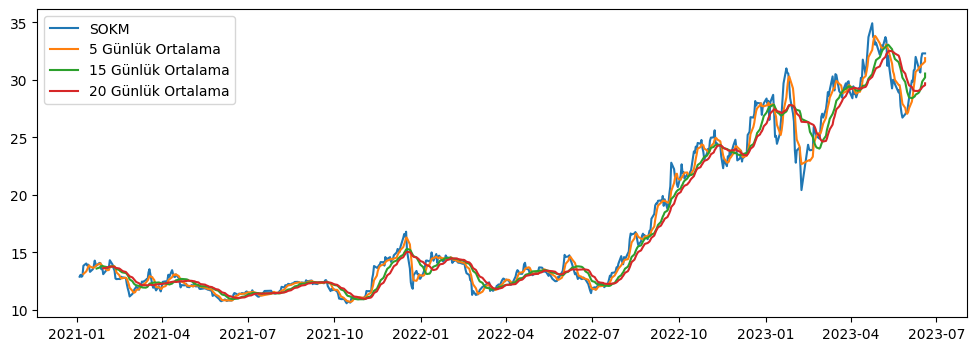

In [20]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='SOKM')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [21]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [22]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

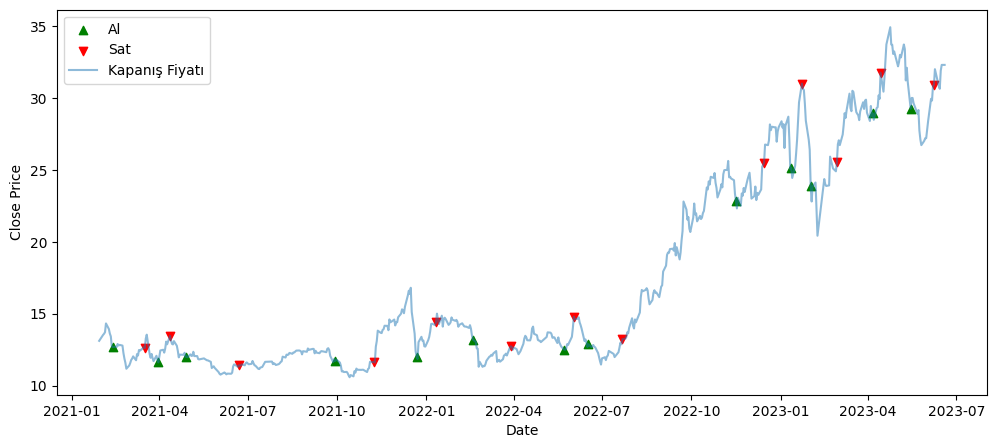

In [23]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [101]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-02-12    12.68
2021-03-31    11.61
2021-04-28    12.00
2021-09-29    11.71
2021-12-22    12.01
2022-02-18    13.20
2022-05-23    12.50
2022-06-17    12.87
2022-11-16    22.84
2023-01-12    25.14
2023-02-01    23.88
2023-04-06    28.92
2023-05-15    29.26
Name: Al, dtype: float64

In [102]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-03-17    12.61
2021-04-12    13.46
2021-06-22    11.42
2021-11-08    11.64
2022-01-11    14.39
2022-03-29    12.73
2022-06-02    14.79
2022-07-22    13.22
2022-12-15    25.50
2023-01-23    31.00
2023-02-28    25.54
2023-04-14    31.76
2023-06-08    30.92
Name: Sat, dtype: float64

In [103]:
sat_val=sat.values
al_val=al.values


In [104]:
sat_val1=sat_val

In [105]:
sat_val1

array([12.61, 13.46, 11.42, 11.64, 14.39, 12.73, 14.79, 13.22, 25.5 ,
       31.  , 25.54, 31.76, 30.92])

In [97]:
al_val1=al_val
al_val1

array([12.68, 11.61, 12.  , 11.71, 12.01, 13.2 , 12.5 , 12.87, 22.84,
       25.14, 23.88, 28.92, 29.26])

In [106]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [107]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,0.994479
1,1.159345
2,0.951667
3,0.994022
4,1.198168
5,0.964394
6,1.183200
7,1.027195
8,1.116462
9,1.233095


In [108]:
res0=[100]
for i in range(len(al_val1)):
    res0.append(res0[i]*df["Kar"].loc[i])


In [109]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,0.994479,99.447950
1,1.159345,115.294522
2,0.951667,109.721953
3,0.994022,109.066058
4,1.198168,130.679482
5,0.964394,126.026500
6,1.183200,149.114555
7,1.027195,153.169729
8,1.116462,171.008235
9,1.233095,210.869343


In [110]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 161.72631161202645


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [111]:
sat_val2=sat_val[1:13:2]

In [112]:
sat_val2

array([13.46, 11.64, 12.73, 13.22, 31.  , 31.76])

In [113]:
al_val2=al_val[0:12:2]
al_val2

array([12.68, 12.  , 12.01, 12.5 , 22.84, 23.88])

In [114]:
res1=[]

for i in range(6):
    res1.append((sat_val2[i]/al_val2[i]))

In [115]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.061514
1,0.970000
2,1.059950
3,1.057600
4,1.357268
5,1.329983


In [116]:
res2=[100]
for i in range(6):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [117]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.061514,106.151420
1,0.970000,102.966877
2,1.059950,109.139746
3,1.057600,115.426195
4,1.357268,156.664275
5,1.329983,208.360862


In [118]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 108.36086156589579
